In [1]:
import os
import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
import tensorflow as tf

2024-11-21 23:24:49.866346: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 23:24:49.964185: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 23:24:49.964246: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 23:24:49.964432: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 23:24:50.001594: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 23:24:50.002189: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# Set the path to the COCO annotations file
coco_dir = "ssl_images/data/coco"
annotations_path = os.path.join(coco_dir, "annotations", "instances_train2017.json")

# initialize COCO api for instance annotations
coco=COCO(annotations_path)

loading annotations into memory...
Done (t=10.56s)
creating index...
index created!


In [3]:
def plot_activations(binary_masks):
    # Plot each ground truth binary mask with its category name
    num_classes = binary_masks.shape[-1]
    fig, axes = plt.subplots(1, num_classes, figsize=(8,5))

    category_names = cat_names
    catIds = coco.getCatIds(catNms=category_names)
    
    for class_idx in range(num_classes):
        ax = axes[class_idx]
        mask = binary_masks[:, :, class_idx]
        ax.imshow(mask, cmap="gray", vmin=0., vmax=1.)
        if class_idx < 3:
            ax.set_title(coco.loadCats(catIds[class_idx])[0]['name'])
        else:
            ax.set_title('bg')
        ax.axis("off")
    
    plt.show()

In [9]:
def visualize_masks(x, y_pred, mask_id=None, alpha=0.5, catNms=None):
    """
    Visualize segmentation masks overlaid on the input image.
    
    Args:
        x: Input image (H, W, C)
        y_pred: Predicted masks (H, W, num_classes)
        mask_id: Optional specific mask to visualize (channel index)
        alpha: Transparency of the overlay
        catNms: List of category names
    """
    if catNms is None:
        catNms = [f"Class {i}" for i in range(y_pred.shape[-1])]
    
    # Get the maximum probability class for each pixel
    max_channel_indices = np.argmax(y_pred, axis=-1)
    
    # Create a figure
    plt.figure(figsize=(10, 3))
    
    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(x)
    plt.title("Original Image")
    plt.axis('off')
    
    # Plot overlay
    plt.subplot(1, 2, 2)
    plt.imshow(x)  # Show the original image first
    
    # Create colormap for different classes
    colors = plt.cm.rainbow(np.linspace(0, 1, len(catNms)))
    
    if mask_id is not None:
        # Show only the specified mask
        mask = y_pred[:, :, mask_id]
        plt.imshow(np.ma.masked_where(mask < 0.5, mask),
                  alpha=alpha,
                  cmap=plt.cm.rainbow,
                  vmin=0, vmax=1)
        plt.title(f"Overlay: {catNms[mask_id]}")
    else:
        # Show all masks with different colors
        colored_mask = np.zeros((*x.shape[:2], 4))  # RGBA
        for i in range(len(catNms)):
            mask = y_pred[:, :, i]
            for c in range(3):  # RGB channels
                colored_mask[:, :, c] = np.where(max_channel_indices == i,
                                               colors[i][c],
                                               colored_mask[:, :, c])
            colored_mask[:, :, 3] = np.where(max_channel_indices == i,
                                           alpha,
                                           colored_mask[:, :, 3])
        plt.imshow(colored_mask)
        plt.title("All Masks Overlay")
    
    # Add legend
    legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=colors[i])
                      for i in range(len(catNms))]
    plt.legend(legend_elements, catNms, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [10]:
# Load and plot images and masks from the preprocessed files
def load_and_plot_preprocessed_data(output_dir, sample_indices, cat_names):
    """
    Load and plot images, grayscale inputs, and masks from preprocessed files.

    Parameters:
    - output_dir: directory where processed files are stored.
    - sample_indices: list of sample indices to load and display.
    - cat_names: list of category names for plotting masks.
    """
    for idx in sample_indices:
        # Load image, grayscale input, and mask
        img_path = os.path.join(output_dir, f"image_{idx}.npy")
        mask_path = os.path.join(output_dir, f"mask_{idx}.npy")

        img = np.load(img_path)
        gt_mask = np.load(mask_path)

        prediction = model.predict(np.expand_dims(img, 0))[0]
        class_indices = tf.argmax(prediction, axis=-1)
        predicted_mask = tf.one_hot(class_indices, depth=4)   
        #predicted_mask = tf.cast(predictions > 0.5, tf.float32)  

        visualize_masks(img, predicted_mask, mask_id=None, catNms=['person', 'car', 'chair', 'background'])

        # Plot ground truth activations
        plot_activations(gt_mask)
        
        # Plot predicted activations
        plot_activations(predicted_mask)   

In [6]:
from src.models.resnet import ResNet18

model = ResNet18((224, 224, 3), mode="segmentation")
model.load_weights('segmentation_ckpt_4_CE/segmentation_model_epoch_008.h5', by_name=True)

2024-11-21 23:25:05.365391: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-21 23:25:05.365776: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Plotting activation maps for TRAINING images
1/1 [==============================] - 0s 68ms/step


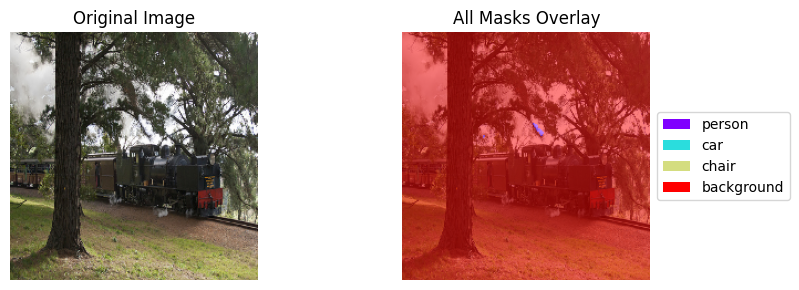

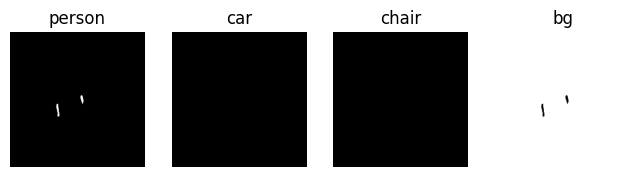

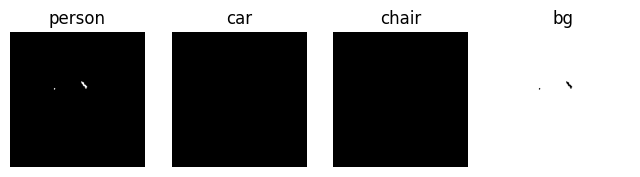

1/1 [==============================] - 0s 55ms/step


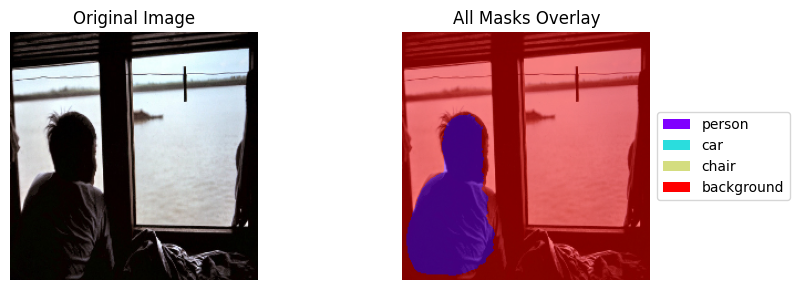

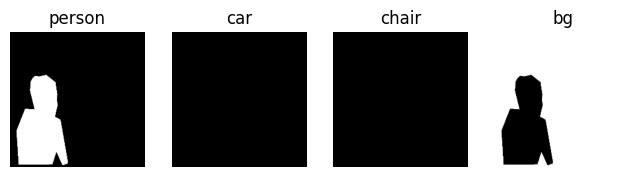

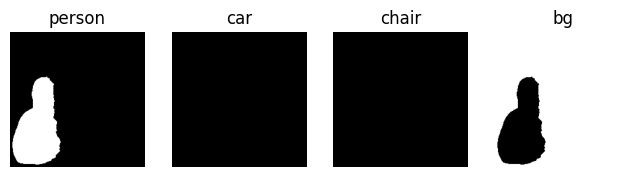

1/1 [==============================] - 0s 67ms/step


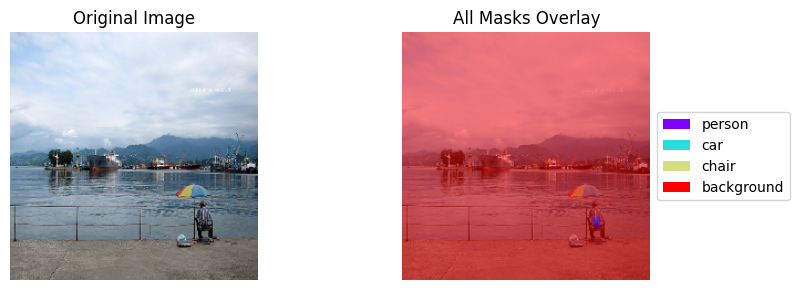

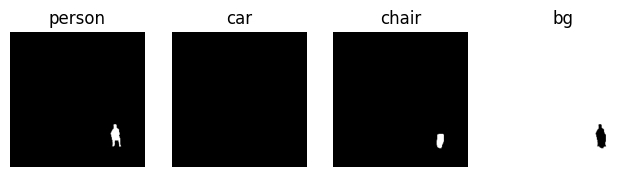

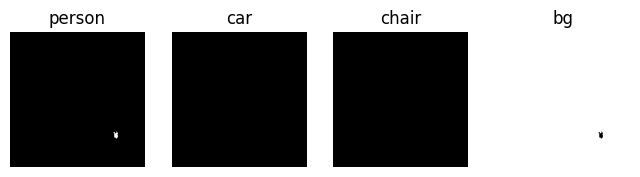

1/1 [==============================] - 0s 62ms/step


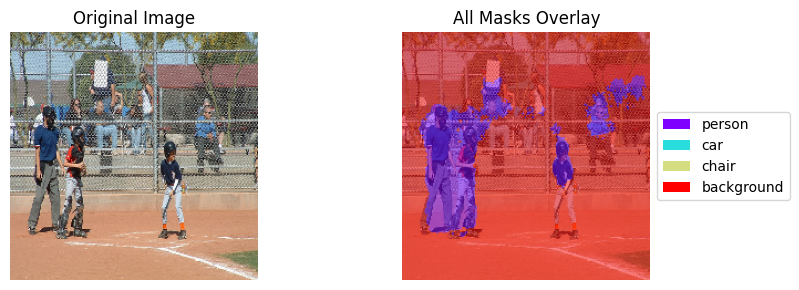

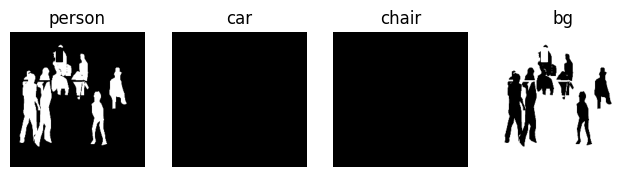

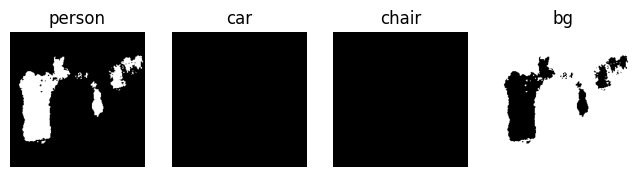

In [11]:
# Define parameters
output_dir = "ssl_images/data/processed/coco/segmentation/train2017"
cat_names = ["person", "car", "chair", 'bg']
sample_indices = [6180, 4772, 1244, 1270]  # Modify this list to view specific samples

print(f'Plotting activation maps for TRAINING images')
# Load and plot data
load_and_plot_preprocessed_data(output_dir, sample_indices, cat_names)


Plotting activation maps for TEST images
1/1 [==============================] - 0s 404ms/step


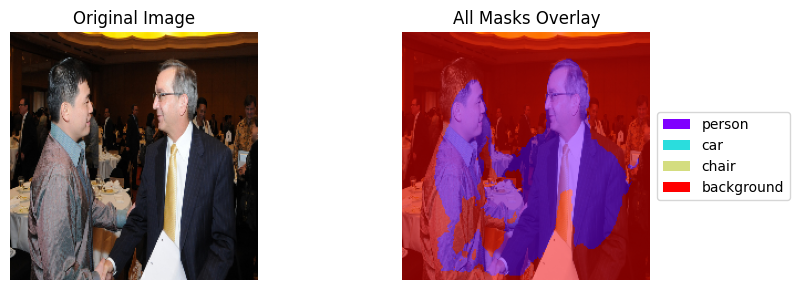

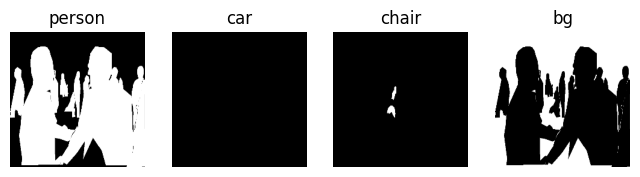

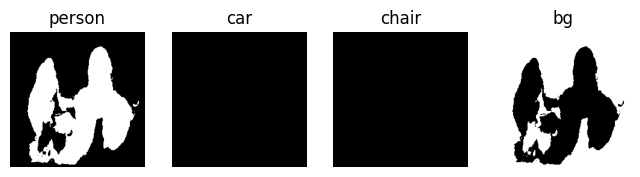

1/1 [==============================] - 0s 58ms/step


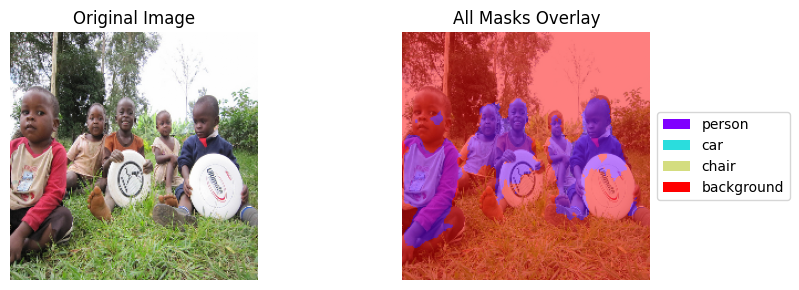

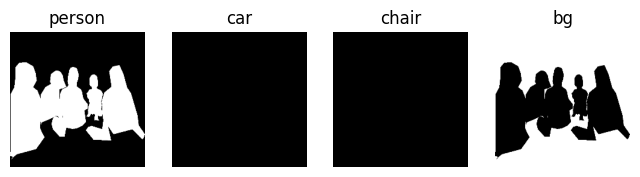

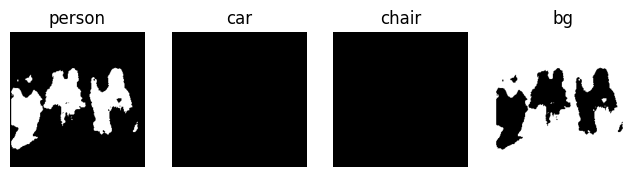

1/1 [==============================] - 0s 64ms/step


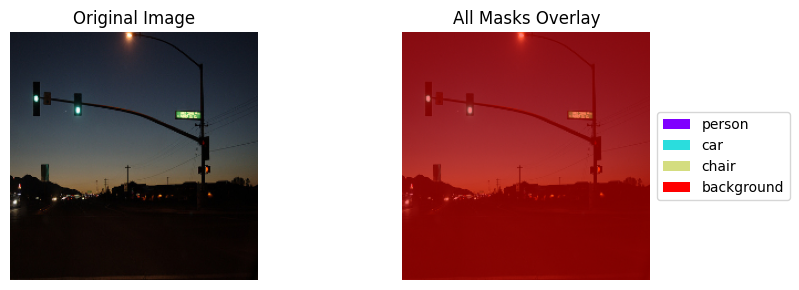

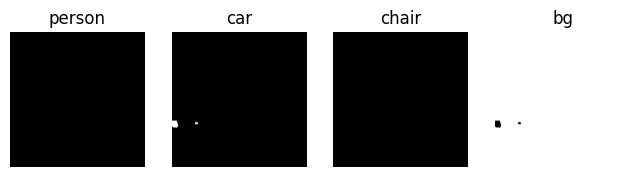

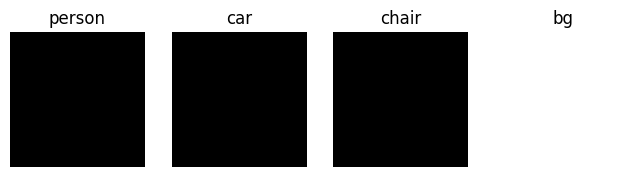

1/1 [==============================] - 0s 56ms/step


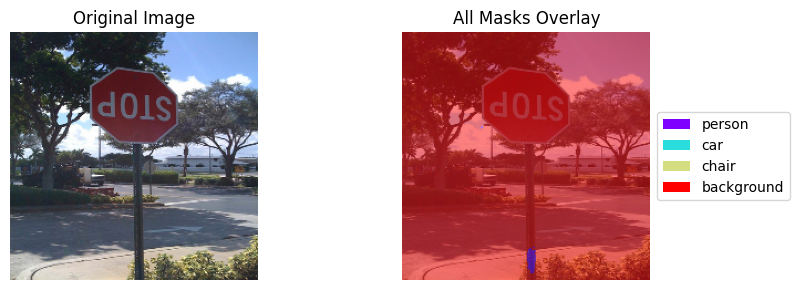

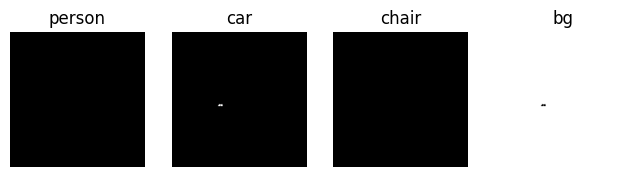

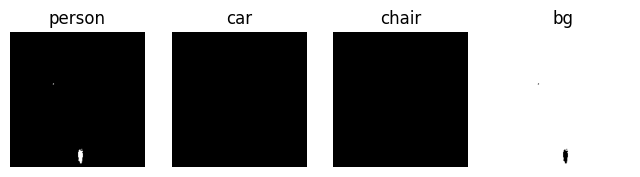

1/1 [==============================] - 0s 56ms/step


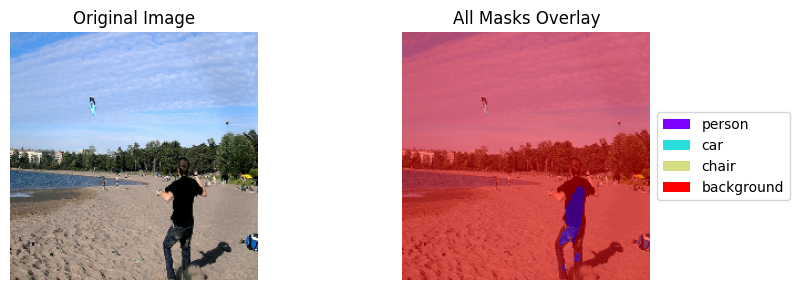

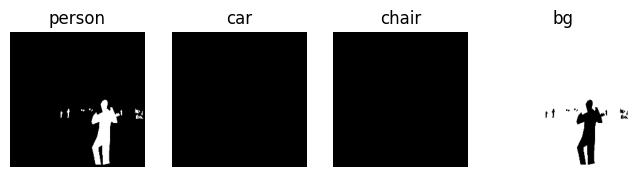

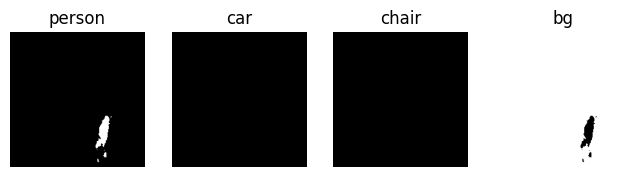

1/1 [==============================] - 0s 60ms/step


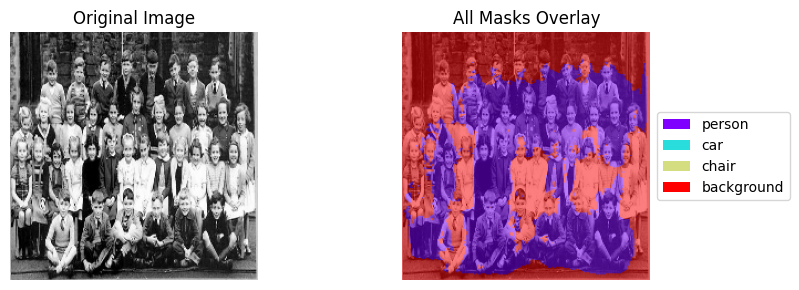

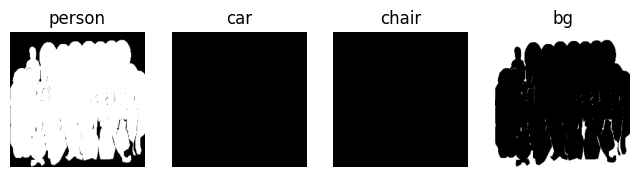

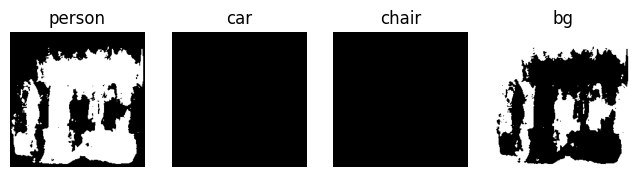

1/1 [==============================] - 0s 53ms/step


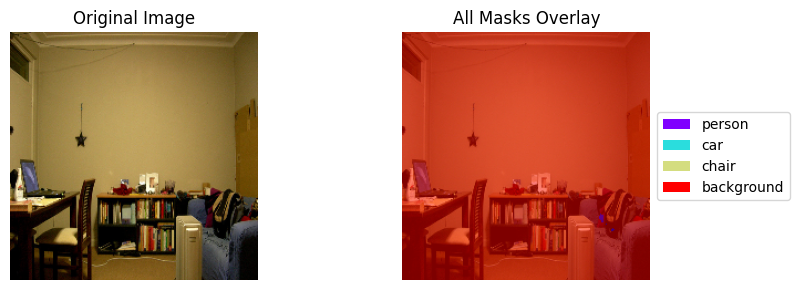

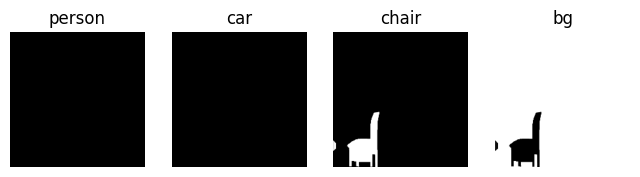

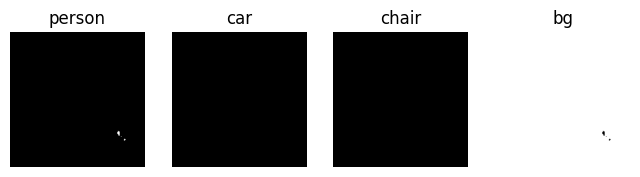

1/1 [==============================] - 0s 53ms/step


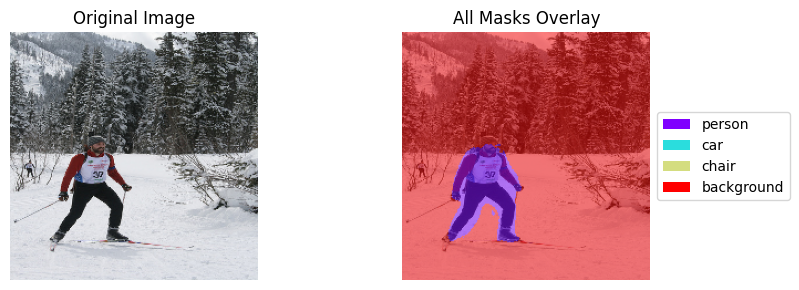

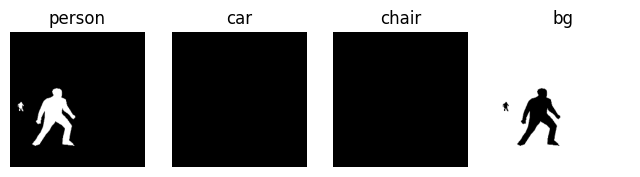

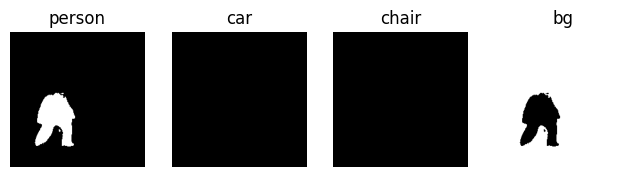

In [15]:
# Define parameters
output_dir = "ssl_images/data/processed/coco/segmentation/val2017"
cat_names = ["person", "car", "chair", 'bg']
sample_indices = [4134, 6954, 8762, 724, 7511, 2299, 24610, 38210]  # Modify this list to view specific samples

print(f'Plotting activation maps for TEST images')

# Load and plot data
load_and_plot_preprocessed_data(output_dir, sample_indices, cat_names)


In [13]:
from src.libs.data_loading import create_dataset_segmentation

def iou_metric(
    y_true: tf.Tensor, y_pred: tf.Tensor, num_classes: int = 3, threshold: float = 0.5
) -> tf.Tensor:
    # Binarize predictions
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)

    # Initialize list to store IoU for each class
    ious = []

    for class_idx in range(num_classes):
        # Extract predictions and ground truth for the current class
        y_true_class = y_true[..., class_idx]
        y_pred_class = y_pred_bin[..., class_idx]

        # Compute intersection and union
        intersection = tf.reduce_sum(y_true_class * y_pred_class, axis=(1, 2))  # Sum over spatial dimensions
        union = (
            tf.reduce_sum(y_true_class, axis=(1, 2))
            + tf.reduce_sum(y_pred_class, axis=(1, 2))
            - intersection
        )

        # Avoid division by zero by using a conditional operation
        iou = tf.where(union > 0, intersection / union, tf.ones_like(union))
        ious.append(iou)

    # Compute mean IoU over all classes
    mean_iou = tf.reduce_mean(tf.stack(ious, axis=0), axis=0)  # Average over classes

    return tf.reduce_mean(mean_iou)  # Average over batch

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[iou_metric],
)

test_dataset = create_dataset_segmentation(
    os.path.join("ssl_images/data", "processed", "coco"),
    split="test",
    batch_size=32,
    single_channel=False,
)

In [18]:
ious = []
for x, y in test_dataset:
    _, iou = model.evaluate(x, y)
    ious.append(iou)

print(f"IOU on test set is {round(sum(ious) / len(ious), 3)}")

1/1 [==============================] - 1s 582ms/step - loss: 0.4386 - iou_metric: 0.6496
IOU on test set is 0.626
